In [745]:
import os
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima.utils import ndiffs
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import itertools
init_notebook_mode(connected=True)
plt.style.use('ggplot')

## utility functions

In [528]:
def adf_report(data):
    result = adfuller(data)
    print(f'ADF Statistic: {result[0]}')
    print(f'n_lags: {result[1]}')
    print(f'p-value: {result[1]}')

def plot_acf_2(df, col):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4))
    ax1.plot(df[col])
    plot_acf(df[col], ax=ax2, lags=10)
    
def plot_pacf_2(df, col):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4))
    ax1.plot(df[col])
    plot_pacf(df[col], ax=ax2, lags=10)
    
def plot_pre_og(df_og, df_pred):
    fig, ax = plt.subplots()
    plt.title('last 30 days actual & next 14 days predicted')
    df_pred['close'].plot(ax=ax, c='r')
    df_og['close'][-30:].plot(ax=ax, c='b')

- data are coming from alphaca API

In [529]:
df_FB = pd.read_csv('FB.csv')
df_FB['timestamp'] = pd.to_datetime(df_FB['timestamp'])
df_FB =df_FB.set_index('timestamp')
df_TWTR = pd.read_csv('TWTR.csv')
df_TWTR['timestamp'] = pd.to_datetime(df_TWTR['timestamp'])
df_TWTR =df_TWTR.set_index('timestamp')

### Methodology
- data is ranging from Dec 2015 to Mar 2022 with daily tick
- Here we gonna use the closing price as time series analysis
- 1. seasonality analysis
- 2. check the distribution of the stock to see if the close price is stationary or not, using ADF (augumented dickey-fuller)
- 3. convert close price to be stationary by finding order of difference
- 4. find the p, d, q in order to use the ARIMA model
- 5. test out ARIMA model
- 6. Then try SARIMA model

### EDA

In [530]:
df_FB['close'].describe()

count    1574.000000
mean      197.806557
std        71.106458
min        94.160000
25%       144.877500
50%       179.620000
75%       239.602500
max       382.180000
Name: close, dtype: float64

<AxesSubplot:xlabel='timestamp'>

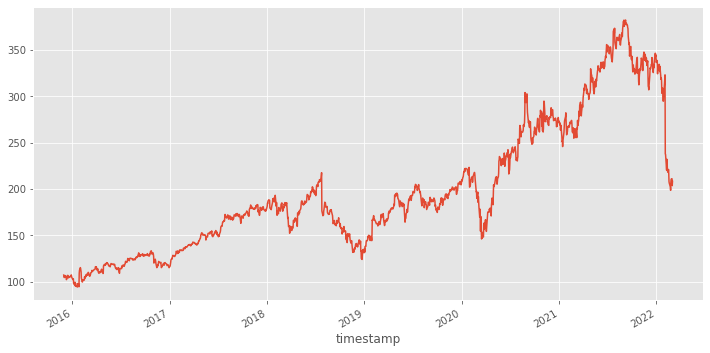

In [531]:
# stock close price movement
df_FB['close'].plot(figsize=(12,6))
# df_FB['volume'].plot(figsize=(12,6), kind='bar')

<AxesSubplot:xlabel='close', ylabel='Density'>

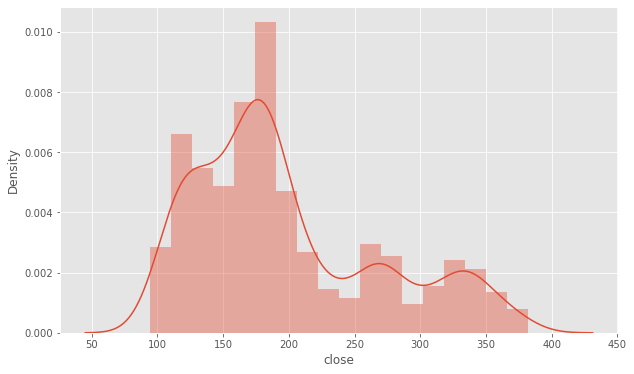

In [532]:
# stock close price distribution
sns.distplot(df_FB['close'])
# df_FB['close'].plot(figsize=(12,6), kind='hist')

## Seasonality Analysis

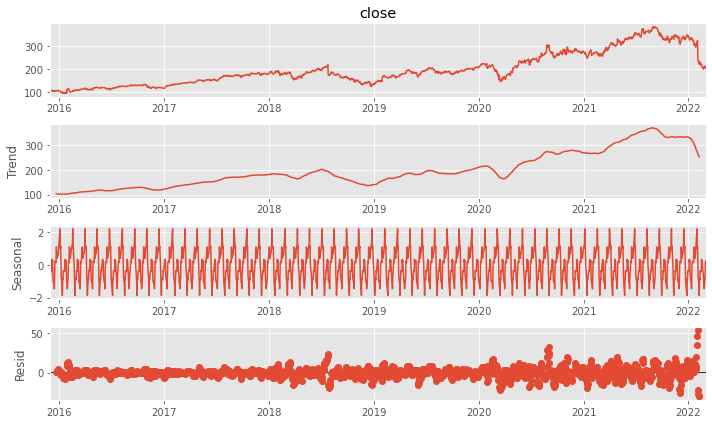

In [533]:
seasonal = seasonal_decompose(df_FB['close'], period = 30)
seasonal.plot();

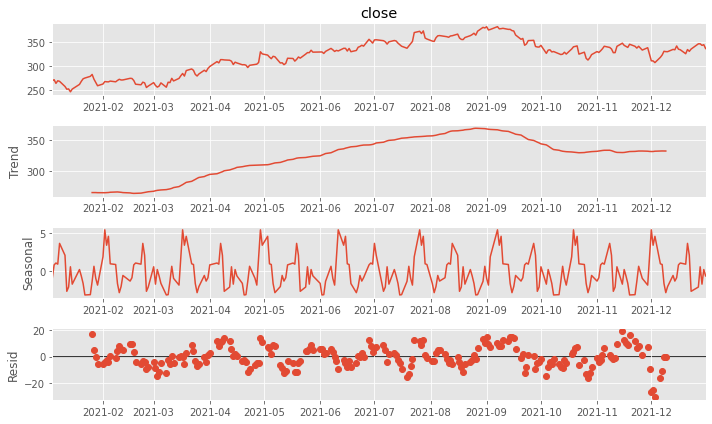

In [534]:
# get data from 2021 only
df_FB_2021 = df_FB[(df_FB.index <= pd.to_datetime('2021-12-31')) & (df_FB.index >= pd.to_datetime('2021-01-01'))]
seasonal_2021 = seasonal_decompose(df_FB_2021['close'], period = 30)
seasonal_2021.plot();

- The overall trend of the stock is going up from late 2015 to 2022
- by looking at 2021 seasonaility for FB, we can see the closing price fluctuates throughout the month
- for example, it goes up in early Feb, but goes down in mid feb and climbing up towards the late feb and falling towards early march.
- Also the seasonaility can be observed in the resid, which is not good.

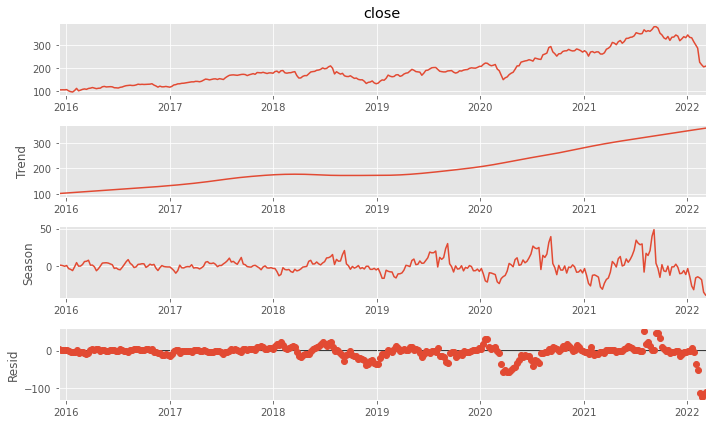

In [535]:
# trying STL to see if it performs better
# has to resample the data to weekly basis to make this work
adj_df_FB_close = df_FB['close'].resample('W').mean().ffill()
stl = STL(adj_df_FB_close,seasonal=29, robust=True)
stl_results = stl.fit()
fig = stl_results.plot()

- The trend is smiliar
- Seasonality is a bit muted from late 2015 to 2019, but more prominent from 2019 onwards.
- less seasonality in the resid

### Stationary Analysis

In [536]:
# augumented dickey-fuller stationary test on the closing price
adf_report(df_FB['close'])

ADF Statistic: -1.5924338302581322
n_lags: 0.48739313677495755
p-value: 0.48739313677495755


- as p-value is bigger than 0.05, so we can't reject the null hypothesis and the closeing price is not stationary
- need to convert it to be staionary

In [537]:
# add close diff order by 1 an order by 2
df_FB['close_1'] = df_FB['close'].diff().fillna(0)
df_FB['close_2'] = df_FB['close_1'].diff().fillna(0)

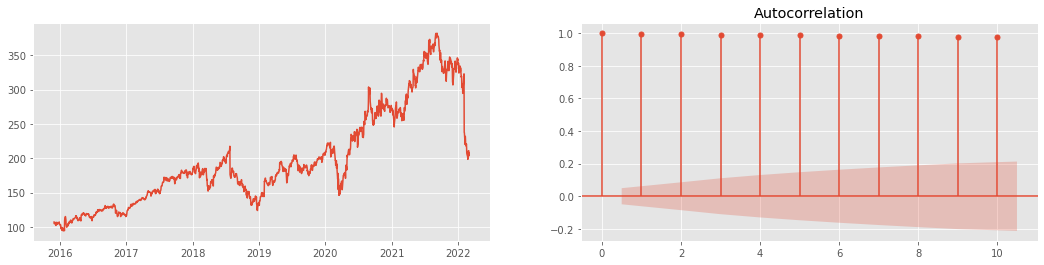

In [538]:
plot_acf_2(df_FB, 'close')

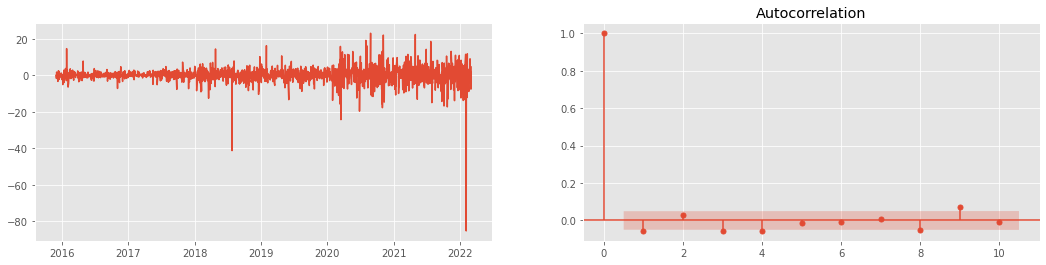

In [539]:
# autocorrelation on closing price by order 1
plot_acf_2(df_FB, 'close_1')

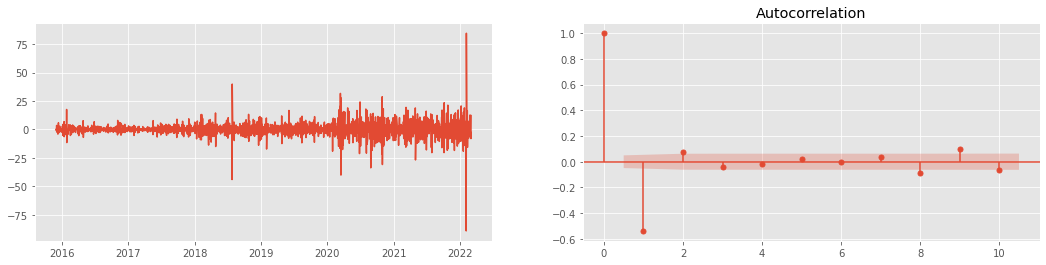

In [540]:
# autocorrelation on closing price by order 2
plot_acf_2(df_FB, 'close_2')

In [541]:
# can also use ndiffs 
ndiffs(df_FB['close'], test='adf')

1

- by using the graph and ndiffs function both agree find order 1 difference of closing price is good enough
- by choosing order 1 difference of closing price (d=1), we can determine the q value 3 seems suitable as it is slightly out the edge from the diagram above with 'close_1', but can use 4, 8 and 9 too. but 3 will be faster to compute
- now we can try partial autocorrelation to see the corrleation between the clsoing price and its lag

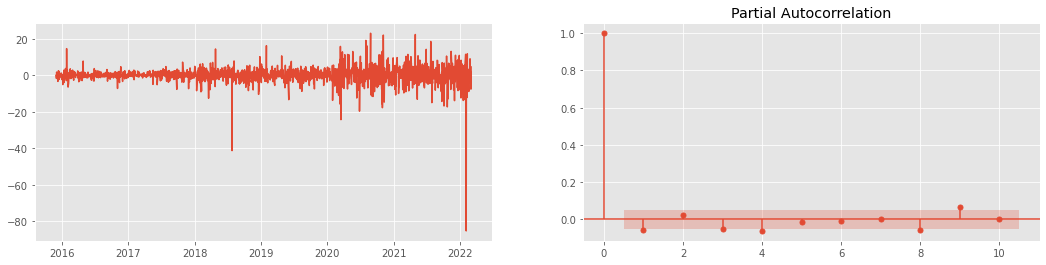

In [542]:
plot_pacf_2(df_FB, 'close_1')

- we can see mutiple p would work, but let's chose the minimum lag outside the confidence zone, which is 1

### ARIMA test

In [543]:
p=1; d=1 ;q=3
model = ARIMA(df_FB['close'], order = (p,d,q))
result_ARIMA = model.fit()
print(f'the aic score is: {result_ARIMA.aic}')

the aic score is: 9404.868732376119


In [544]:
print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1876      0.469      0.400      0.689      -0.732       1.108
ar.L2          0.3942      0.274      1.439      0.150      -0.143       0.931
ma.L1         -0.2571      0.470     -0.548      0.584      -1.178       0.663
ma.L2         -0.3801      0.289     -1.316      0.188      -0.946       0.186
ar.S.L5       -0.9630      0.052    -18.670      0.000      -1.064      -0.862
ar.S.L10       0.0139      0.032      0.432      0.666      -0.049       0.077
ma.S.L5       -0.0362      0.117     -0.309      0.757      -0.266       0.193
ma.S.L10      -0.9632      0.104     -9.276      0.000      -1.167      -0.760
sigma2        23.0202      2.361      9.749      0.000      18.392      27.648


- can remove the terms with high p value or low coefficient

<AxesSubplot:xlabel='timestamp'>

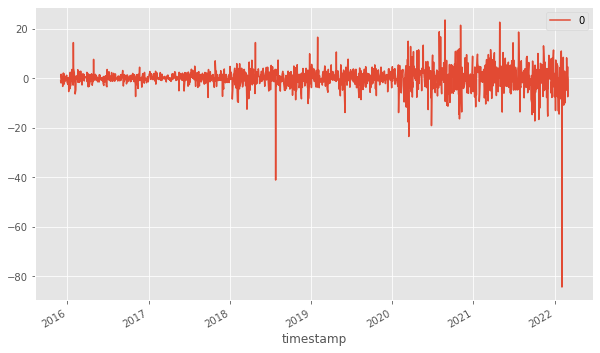

In [545]:
residuals = pd.DataFrame(result_ARIMA.resid)
residuals.plot()

<AxesSubplot:ylabel='Density'>

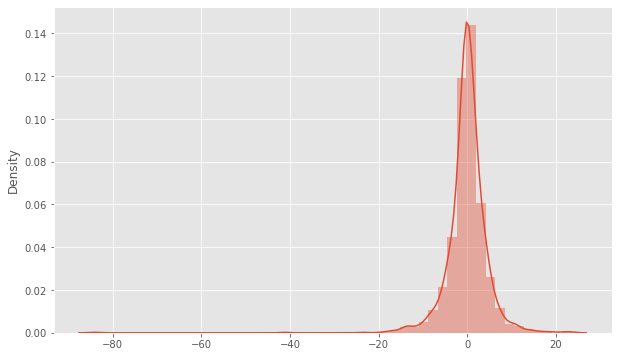

In [546]:
sns.distplot(residuals)

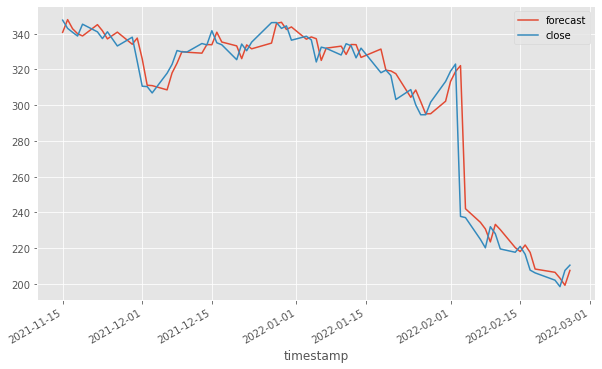

In [547]:
result_ARIMA.plot_predict(
    start =1500,
    end = 1570,
    dynamic = False
);

In [548]:
# finding the last day of the training dataset
df_FB_last_day = df_FB.tail(1).index.values[0]
start_date = df_FB_last_day + np.timedelta64(1, 'D')
end_date = df_FB_last_day + np.timedelta64(15, 'D')
forecate_range = []

for i in range(0, 14):
    iter_date = start_date
    iter_date += np.timedelta64(i, 'D')
    forecate_range.append(iter_date)
    

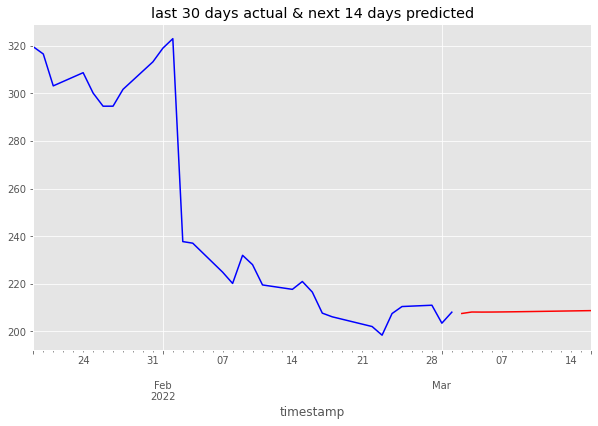

In [549]:
ARIMA_forecast = result_ARIMA.forecast(steps=14)[0]
df_ARIMA_forecast = pd.DataFrame({'timestamp':forecate_range
                                  , 'close': ARIMA_forecast})
df_ARIMA_forecast = df_ARIMA_forecast.set_index('timestamp')
plot_pre_og(df_FB, df_ARIMA_forecast)

### SARIMA
- we will try to use SARIMA as it has seasonailty compent in it
- and p,d,q value we keep as same as ARIMA model and s we use 5 days, as there is 5 trading days

In [550]:
p=1; d=1 ;q=3
model_SARIMAX = SARIMAX(df_FB['close'], order=(p, d, q),seasonal_order=(p, d, q, 5))
results_SARIMAX = model_SARIMAX.fit()

In [551]:
print(results_SARIMAX.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             close   No. Observations:                 1574
Model:             SARIMAX(1, 1, 3)x(1, 1, 3, 5)   Log Likelihood               -4695.203
Date:                           Sat, 05 Mar 2022   AIC                           9408.406
Time:                                   18:46:12   BIC                           9456.624
Sample:                                        0   HQIC                          9426.329
                                          - 1574                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4844      0.225      2.152      0.031       0.043       0.926
ma.L1         -0.5443      0.223     -2.436

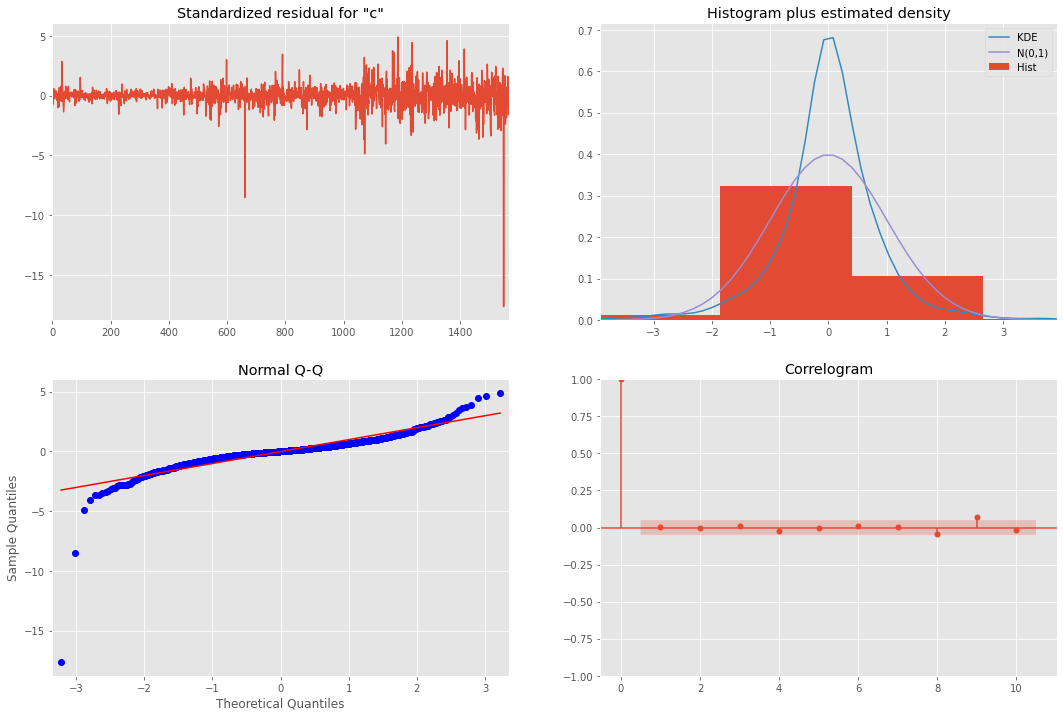

In [552]:
results_SARIMAX.plot_diagnostics(figsize=(18, 12));

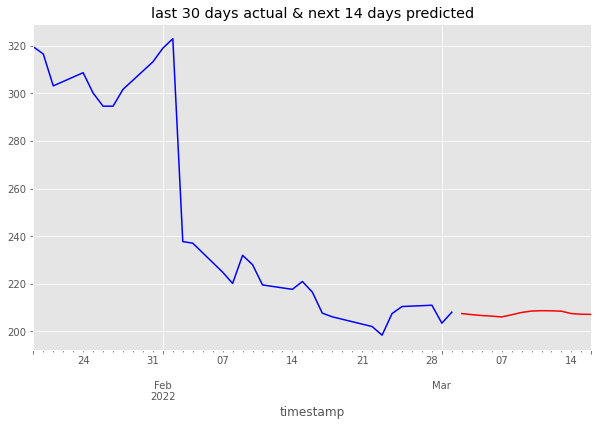

In [553]:
SARIMA_forecast = results_SARIMAX.forecast(steps=14).to_list()
df_SARIMA_forecast = pd.DataFrame({'timestamp':forecate_range
                                  , 'close': SARIMA_forecast})
df_SARIMA_forecast = df_SARIMA_forecast.set_index('timestamp')
plot_pre_og(df_FB, df_SARIMA_forecast)

### Tuning the SARIMAX model

In [554]:
# let's see it it works with other parameters by using aic to see which combo has the lowest score
# set parameter range
p,d,q = range(0,3),[1],range(0,3)
P,D,Q,s = range(0,3),[1],range(0,3),[5]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
combined_parameter = list(itertools.product(pdq,seasonal_pdq))

In [555]:
%%time
SARIMAX_performance = []
for para in combined_parameter:
    model = SARIMAX(df_FB['close'], order=para[0] ,seasonal_order=para[1])
    result = model.fit()
    SARIMAX_performance.append([para,result.aic])
    print(f'pdq: {para[0]}, spdq: {para[1]}, and AIC: {result.aic:.3f}')

pdq: (0, 1, 0), spdq: (0, 1, 0, 5), and AIC: 10487.202
pdq: (0, 1, 0), spdq: (0, 1, 1, 5), and AIC: 9413.578
pdq: (0, 1, 0), spdq: (0, 1, 2, 5), and AIC: 9415.406
pdq: (0, 1, 0), spdq: (1, 1, 0, 5), and AIC: 10036.115
pdq: (0, 1, 0), spdq: (1, 1, 1, 5), and AIC: 9415.406
pdq: (0, 1, 0), spdq: (1, 1, 2, 5), and AIC: 9413.269
pdq: (0, 1, 0), spdq: (2, 1, 0, 5), and AIC: 9870.556
pdq: (0, 1, 0), spdq: (2, 1, 1, 5), and AIC: 9417.340
pdq: (0, 1, 0), spdq: (2, 1, 2, 5), and AIC: 9415.229
pdq: (0, 1, 1), spdq: (0, 1, 0, 5), and AIC: 10488.478
pdq: (0, 1, 1), spdq: (0, 1, 1, 5), and AIC: 9411.208
pdq: (0, 1, 1), spdq: (0, 1, 2, 5), and AIC: 9412.899
pdq: (0, 1, 1), spdq: (1, 1, 0, 5), and AIC: 10028.154
pdq: (0, 1, 1), spdq: (1, 1, 1, 5), and AIC: 9412.899
pdq: (0, 1, 1), spdq: (1, 1, 2, 5), and AIC: 9410.195
pdq: (0, 1, 1), spdq: (2, 1, 0, 5), and AIC: 9862.714
pdq: (0, 1, 1), spdq: (2, 1, 1, 5), and AIC: 9414.899
pdq: (0, 1, 1), spdq: (2, 1, 2, 5), and AIC: 9412.185
pdq: (0, 1, 2), spdq: (0

In [556]:
SARIMAX_performance.sort(key=lambda x: x[1])
SARIMAX_performance[0]

[((1, 1, 0), (1, 1, 2, 5)), 9409.979198786521]

- seems like pdq = (1, 1, 0) and spdq = (1, 1, 2, 5) performs the best with the AIC of 9409.98
- we can use this set of pararmeters to predict the stock price

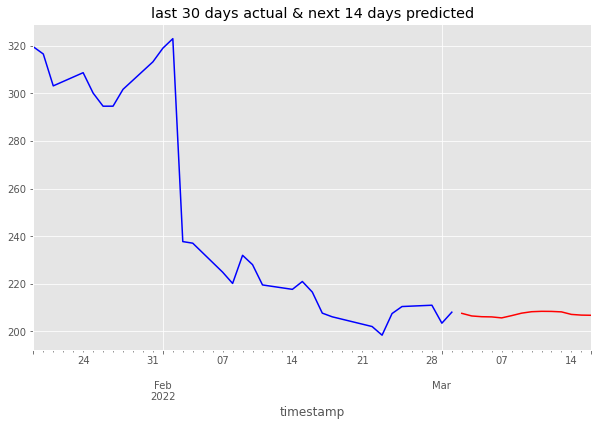

In [557]:
model_SARIMAX = SARIMAX(df_FB['close'], order=SARIMAX_performance[0][0][0] ,seasonal_order=SARIMAX_performance[0][0][1])
results_SARIMAX = model_SARIMAX.fit()
SARIMA_forecast = results_SARIMAX.forecast(steps=14).to_list()
df_SARIMA_forecast = pd.DataFrame({'timestamp':forecate_range
                                  , 'close': SARIMA_forecast})
df_SARIMA_forecast = df_SARIMA_forecast.set_index('timestamp')
plot_pre_og(df_FB, df_SARIMA_forecast)

### compare the best SARIMA and ARIMA model in a graph

<AxesSubplot:title={'center':'last 30 days actual & next 14 days predicted SARIMA (red) - ARIMA (orange)'}, xlabel='timestamp'>

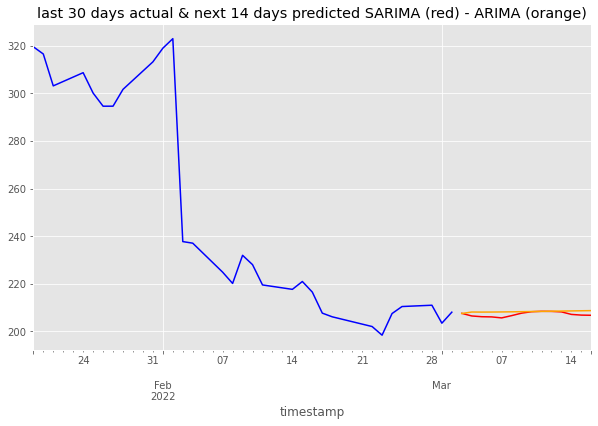

In [558]:
fig, ax = plt.subplots()
plt.title('last 30 days actual & next 14 days predicted SARIMA (red) - ARIMA (orange)')
df_SARIMA_forecast['close'].plot(ax=ax, c='r')
df_ARIMA_forecast['close'].plot(ax=ax, c='orange')
df_FB['close'][-30:].plot(ax=ax, c='b')


- although ARIMA has a lower AIC score, but I think SARIMA is a more realistic model for forecasting, as stock data usually contains seasonality 

### Mean Reversion Pair trading

In [559]:
import yfinance as yf
import pandas_datareader as pdr
from datetime import datetime

- Take a few stocks from NASDQ/NYSE and find their correlations in order to find a pair

In [631]:
def get_historical_Data_all(tickers):
    data = []
    for i in tickers:
        df_inter = yf.download(i, start=datetime(2021, 1, 1), end=datetime(2021, 12, 31))
        df_inter.columns = [f'{col}_{i}' for col in df_inter.columns]
        data.append(df_inter)
    output = pd.concat(data, axis=1)
    return output

def get_historical_Data_close(tickers):
    data = []
    stock_id =[]
    for i in tickers:
        data.append(yf.download(i, start=datetime(2021, 1, 1), end=datetime(2021, 12, 31))['Close'])
        stock_id.append(i)
    output = pd.concat(data, axis=1)
    output.columns = stock_id
    return output

ticks = ['MSFT', 'PG', 'MA', 'PYPL', 'BABA', 'JPM', 'PFE', 'KO', 'V', 'BA', 'NVDA', 'JNJ', 'SNOW', 'ATVI', 'F', 'HPQ', 'DELL', 'NATI', 'AXP', 'NKE', 'FB'] 
df_allstock = get_historical_Data_close(ticks)
print(df_allstock.shape)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [562]:
corr = df_allstock.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,MSFT,PG,MA,PYPL,BABA,JPM,PFE,KO,V,BA,NVDA,JNJ,SNOW,ATVI,F,HPQ,DELL,NATI,AXP,NKE,FB
MSFT,1.00,0.85,-0.20,-0.37,-0.89,0.63,0.88,0.73,0.02,-0.40,0.96,0.25,0.77,-0.87,0.85,0.45,0.84,-0.13,0.75,0.84,0.69
PG,0.85,1.00,-0.19,-0.51,-0.89,0.46,0.94,0.75,-0.02,-0.45,0.84,0.34,0.66,-0.84,0.73,0.51,0.70,-0.13,0.55,0.73,0.60
MA,-0.20,-0.19,1.00,0.45,0.24,0.13,-0.23,0.30,0.79,0.70,-0.30,0.23,-0.58,0.40,-0.17,0.20,0.09,-0.06,0.28,-0.21,0.22
PYPL,-0.37,-0.51,0.45,1.00,0.47,-0.16,-0.54,-0.08,0.68,0.40,-0.50,0.30,-0.48,0.66,-0.59,-0.55,-0.32,-0.10,0.02,-0.21,0.22
BABA,-0.89,-0.89,0.24,0.47,1.00,-0.65,-0.90,-0.68,0.00,0.40,-0.88,-0.17,-0.68,0.91,-0.78,-0.45,-0.81,0.29,-0.69,-0.72,-0.64
JPM,0.63,0.46,0.13,-0.16,-0.65,1.00,0.47,0.64,0.28,0.18,0.56,0.12,0.28,-0.47,0.62,0.46,0.84,-0.44,0.85,0.40,0.59
PFE,0.88,0.94,-0.23,-0.54,-0.90,0.47,1.00,0.73,-0.06,-0.48,0.89,0.36,0.67,-0.88,0.79,0.55,0.73,-0.14,0.55,0.76,0.61
KO,0.73,0.75,0.30,-0.08,-0.68,0.64,0.73,1.00,0.49,0.00,0.65,0.60,0.28,-0.50,0.61,0.49,0.77,-0.31,0.80,0.60,0.84
V,0.02,-0.02,0.79,0.68,0.00,0.28,-0.06,0.49,1.00,0.46,-0.13,0.49,-0.40,0.27,-0.14,-0.05,0.23,-0.37,0.53,0.07,0.58
BA,-0.40,-0.45,0.70,0.40,0.40,0.18,-0.48,0.00,0.46,1.00,-0.45,-0.04,-0.67,0.55,-0.24,0.08,-0.02,-0.06,0.11,-0.46,0.02


- NVDA and MSFT seems have quite high correlations in 2021, let's explore their closing price, spread, ratio
- Then to check if the dataset is stationary by using cointegration and adf
- After exploring, decided to use diff order 1 of the ratio between 'JPM', 'AXP' as the indicator for the pairs trading strategy
- then use diff order 1 of the ratio of rolling average 5 day and 30 day to calculate the zscore again

Text(0.5, 1.0, 'Close price')

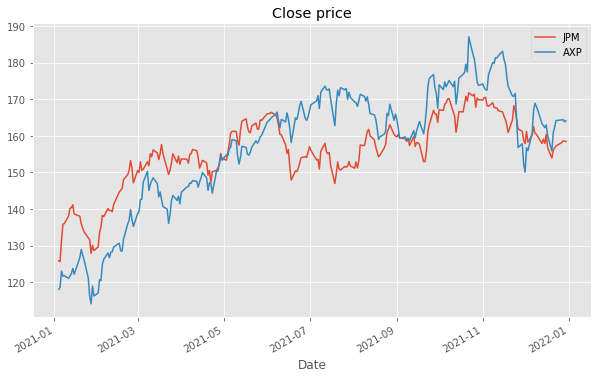

In [598]:
# stock price JP Morgan vs american express 0.85 correlations
stock1 = 'JPM'; stock2 = 'AXP'
df_allstock[[stock1, stock2]].plot()
plt.title('Close price')

Text(0.5, 1.0, 'spread')

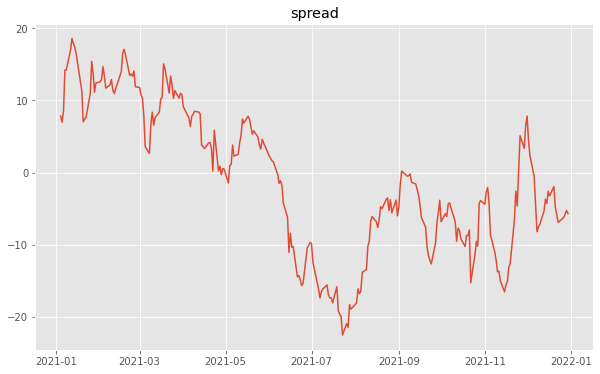

In [599]:
# see the spread between JPM and AXP
plt.plot(df_allstock[stock1] - df_allstock[stock2])
plt.title('spread')

Text(0.5, 1.0, 'close price ratio (JPM/AXP)')

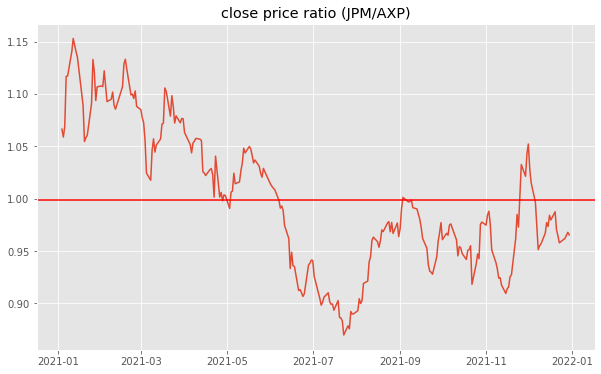

In [600]:
# see the ratio between JPM and AXP
price_ratio = df_allstock[stock1] / df_allstock[stock2]
# fig, ax = plt.subplots()
plt.plot(price_ratio)
plt.axhline(price_ratio.mean(), c='r')
plt.title('close price ratio (JPM/AXP)')

In [692]:
import statsmodels.tsa.stattools as ts
coninter = ts.coint(df_allstock[stock1], df_allstock[stock2])
print(f't-statistic: {coninter[0]}')
print(f'The p value is {coninter[1]}')
print("The p-value is bigger than 0.05, so reject the null hypothesis! which means cointergration doesn't exisit, hence they are not similar enough")

t-statistic: -2.9894696610424636
The p value is 0.11272981154979189
The p-value is bigger than 0.05, so reject the null hypothesis! which means cointergration doesn't exisit, hence they are not similar enough


In [689]:
coninter

(-2.9894696610424636,
 0.11272981154979189,
 array([-3.94078403, -3.36067957, -3.06145832]))

Maybe should try to pick another pair instead, but let's use this pair for the time being.

In [602]:
# try adf
# print('JPM_adf')
# JPM_adf = adf_report(df_allstock['JPM'])
# print('\nAXP_adf')
# AXP_adf = adf_report(df_allstock['AXP'])
print('\nspread_adf')
spread_adf = adf_report(df_allstock[stock1] - df_allstock[stock2])
print('\nratio_adf')
ratio_adf = adf_report(df_allstock[stock1] /df_allstock[stock2])
print('\nratio_adf order diff 1')
ratio_adf_1 = (df_allstock[stock1] /df_allstock[stock2]).diff().dropna()
adf_report(ratio_adf_1)


spread_adf
ADF Statistic: -2.0904339658197317
n_lags: 0.2483785091481377
p-value: 0.2483785091481377

ratio_adf
ADF Statistic: -1.7459803353825822
n_lags: 0.4075911535877767
p-value: 0.4075911535877767

ratio_adf order diff 1
ADF Statistic: -9.734223078545744
n_lags: 8.83802359178037e-17
p-value: 8.83802359178037e-17


In [603]:
# let's plot the stationaised ratio with z score
zscore = (ratio_adf_1 - ratio_adf_1.mean())/ratio_adf_1.std()
# find the band value
upper_high = zscore.quantile(0.95)
upper_low = zscore.quantile(0.85)
lower_high = zscore.quantile(0.10)
lower_low = zscore.quantile(0.20)

Text(0.5, 1.0, 'zscore for close price ratio diff order 1 (JPM/AXP)')

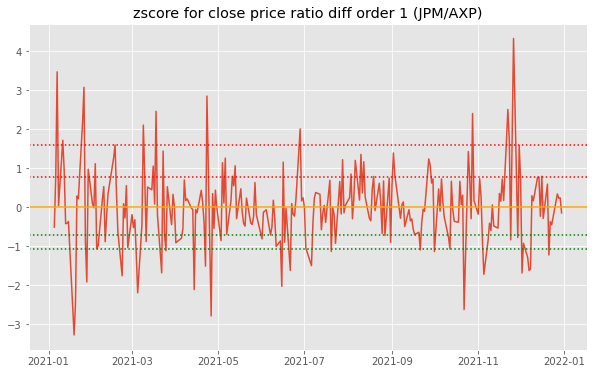

In [604]:
plt.plot(zscore)
plt.axhline(zscore.mean(), c='orange')
plt.axhline(upper_high, c='r', linestyle = 'dotted')
plt.axhline(upper_low, c='r', linestyle = 'dotted')
plt.axhline(lower_high, c='g', linestyle = 'dotted')
plt.axhline(lower_low , c='g', linestyle = 'dotted')
plt.title('zscore for close price ratio diff order 1 (JPM/AXP)')

In [605]:
# calculate the zscore for rolling average 5 day and 30 day
ratio_adf_1_mv5 = ratio_adf_1.rolling(window=5, center=False).mean()
ratio_adf_1_mv30 = ratio_adf_1.rolling(window=30, center=False).mean()
std_30 = ratio_adf_1.rolling(window=20, center=False).std()
# zscore
zscore_30_5 = (ratio_adf_1_mv5 - ratio_adf_1_mv30)/std_30


Text(0, 0.5, 'Ratio')

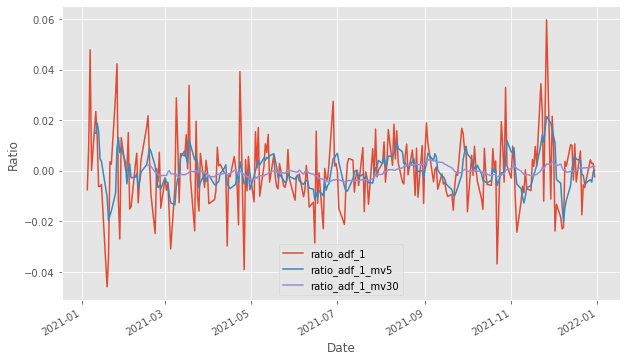

In [606]:
# ploting the 
ratio_adf_1.plot()
ratio_adf_1_mv5.plot()
ratio_adf_1_mv30.plot()
plt.legend(['ratio_adf_1', 'ratio_adf_1_mv5', 'ratio_adf_1_mv30'])
plt.xlabel('Date')
plt.ylabel('Ratio')

Text(0.5, 1.0, 'zscore_30_5 ratio zscore')

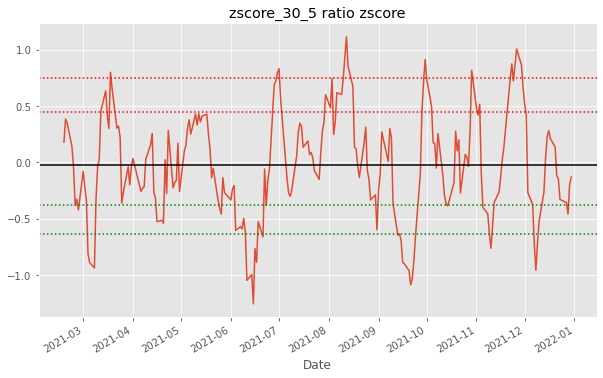

In [607]:
# plot the zscore_30_5 ratio zscore
upper_high_30_5 = zscore_30_5.quantile(0.95)
upper_low_30_5 = zscore_30_5.quantile(0.85)
lower_high_30_5 = zscore_30_5.quantile(0.10)
lower_low_30_5 = zscore_30_5.quantile(0.20)
zscore_30_5.plot()
plt.axhline(zscore_30_5.mean(), c='black')
plt.axhline(upper_high_30_5, c='r', linestyle = 'dotted')
plt.axhline(upper_low_30_5, c='r', linestyle = 'dotted')
plt.axhline(lower_high_30_5, c='g', linestyle = 'dotted')
plt.axhline(lower_low_30_5 , c='g', linestyle = 'dotted')
plt.title('zscore_30_5 ratio zscore')

In [608]:
def buy_sginal(zscore, price_ratio, lower_band):
    if zscore < lower_band:
        return price_ratio
    else:
        return 0
    
def sell_sginal(zscore, price_ratio, higher_band):
    if zscore > higher_band:
        return price_ratio
    else:
        return 0

In [739]:
df_signal = pd.concat([price_ratio, zscore_30_5], axis=1)
df_signal.columns = ['price_ratio', 'zscore_30_5']
df_signal.fillna(0, inplace=True)
df_signal['buy'] = df_signal.apply(lambda x: buy_sginal(x['zscore_30_5'],  x['price_ratio'], lower_low_30_5), 1)
df_signal['sell'] = df_signal.apply(lambda x: sell_sginal(x['zscore_30_5'], x['price_ratio'], upper_low_30_5), 1)

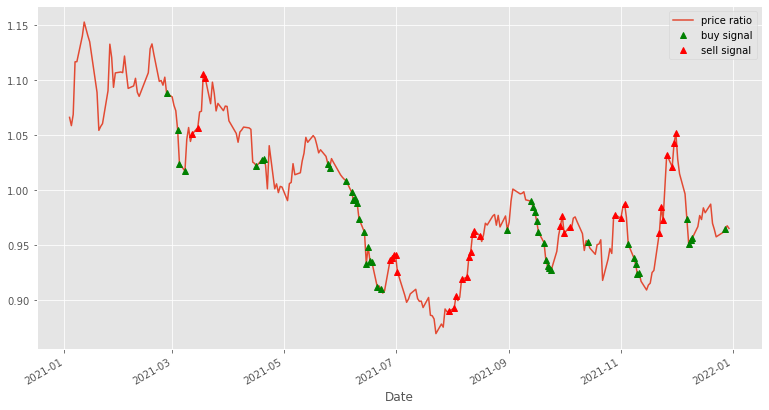

In [740]:
plt.subplots(figsize=(13,7))
df_signal['price_ratio'].plot()
df_signal[df_signal['buy']!= 0]['buy'].plot(color='g', linestyle='None', marker='^')
df_signal[df_signal['sell']!= 0]['sell'].plot(color='r', linestyle='None', marker='^')
plt.legend(['price ratio', 'buy signal', 'sell signal'])

In [741]:
# back testing a bit
df_open_close = get_historical_Data_all(['JPM', 'AXP'])
df_open_close = df_open_close[['Open_JPM', 'Close_JPM', 'Open_AXP','Close_AXP' ]]
df_signal_results = pd.concat([df_signal, df_open_close], axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


#### trading strategy 
- always buy and sell 1 stock each
- sell at the sell signal day close price 
- buy at the buy the open price of the next day after signal day

In [744]:
class trade_exe:
    def __init__(self):
        pass
    
    def find_sell_price(self, df):
        df_sell = df[df['sell'] != 0][['Close_JPM', 'Close_AXP']]
        df_sell.columns = ['Close_JPM_sell', 'Close_AXP_sell']
        return pd.concat([df, df_sell], axis=1)
    
    def find_buy_price(self, df):
        df = df.shift(1)
        df_buy = df[df['buy'] != 0][['Open_JPM', 'Open_AXP']]
        df_buy.columns = ['Open_JPM_buy', 'Open_AXP_buy']
        return pd.concat([df, df_buy], axis=1)
    
    def exe(self, df):
        df = self.find_sell_price(df)
        df = self.find_buy_price(df)
        JPM_last_price = df.tail(1)['Close_JPM'].values[0]
        AXP_last_price = df.tail(1)['Close_AXP'].values[0]
        df2 = df[['price_ratio', 'Close_JPM_sell', 
                  'Close_AXP_sell','Open_JPM_buy', 'Open_AXP_buy']].dropna(subset = ['Close_JPM_sell', 'Close_AXP_sell',
                                                                                     'Open_JPM_buy', 'Open_AXP_buy'], how='all', axis= 0)
        JPM_long_count = 0; JPM_long_value= 0
        AXP_long_count = 0; AXP_long_value= 0
        balance = 10000
        for index, row in df2.iterrows():
            if row['price_ratio'] > 1:

                if pd.isnull(row['Open_AXP_buy']) == False:
                    # AXA long trades buy
                    AXP_long_count += 1
                    AXP_long_value += row['Open_AXP_buy']
                    balance -= row['Open_AXP_buy']
                    print('buy AXP', index, AXP_long_count, AXP_long_value)
                elif pd.isnull(row['Close_AXP_sell']) == False:
                    # AXA long trades short
                    AXP_long_count -= 1
                    AXP_long_value -= row['Close_AXP_sell']
                    balance += row['Close_AXP_sell']
                    print('sell AXP', index, AXP_long_count, AXP_long_value)
            elif row['price_ratio'] < 1:
                if pd.isnull(row['Open_JPM_buy']) == False:
                    # JPM long trades buy
                    JPM_long_count += 1
                    JPM_long_value += row['Open_JPM_buy']
                    balance -= row['Open_AXP_buy']
                    print('buy JPM', index, JPM_long_count, JPM_long_value)
                elif pd.isnull(row['Close_JPM_sell']) == False:
                    # JPM long trades sell
                    JPM_long_count -= 1
                    JPM_long_value -= row['Close_JPM_sell']
                    balance += row['Close_JPM_sell']
                    print('sell JPM', index, JPM_long_count, JPM_long_value)
        JPM_final_value = JPM_last_price*JPM_long_count
        AXP_final_value = AXP_last_price*AXP_long_count
        Total_asset = balance+JPM_final_value+AXP_final_value
        profit_loss = (Total_asset - 100000)/100000
        print('''############### Final result #################''')
        print(f'''initial_balance: 100000, final_balance: {balance}, JPM_value: {JPM_final_value}, 
                APX_value: {AXP_final_value}, total_asset_value: {Total_asset}, profit_loss: {profit_loss:.2f}%''')           
#         return df2

sess= trade_exe()
sess.exe(df_signal_results)

buy AXP 2021-03-01 00:00:00 1 137.10000610351562
buy AXP 2021-03-05 00:00:00 2 279.25
buy AXP 2021-03-08 00:00:00 3 423.9100036621094
buy AXP 2021-03-09 00:00:00 4 571.1900024414062
sell AXP 2021-03-15 00:00:00 3 422.65000915527344
sell AXP 2021-03-16 00:00:00 2 275.6600036621094
sell AXP 2021-03-19 00:00:00 1 133.0800018310547
sell AXP 2021-03-22 00:00:00 0 -7.6300048828125
buy AXP 2021-04-19 00:00:00 1 142.0800018310547
buy AXP 2021-04-20 00:00:00 2 291.27000427246094
buy AXP 2021-04-21 00:00:00 3 438.4800109863281
buy AXP 2021-05-26 00:00:00 4 597.5500183105469
buy AXP 2021-05-27 00:00:00 5 755.7100219726562
buy AXP 2021-06-07 00:00:00 6 920.7100219726562
buy JPM 2021-06-08 00:00:00 1 167.0
buy JPM 2021-06-09 00:00:00 2 331.49000549316406
buy JPM 2021-06-10 00:00:00 3 495.6300048828125
buy JPM 2021-06-11 00:00:00 4 659.9900054931641
buy JPM 2021-06-14 00:00:00 5 820.4199981689453
buy JPM 2021-06-15 00:00:00 6 980.5699920654297
buy JPM 2021-06-16 00:00:00 7 1137.2699890136719
buy JPM

- As we can observe, the pairs trading strategy between JPM and APX does not generate profit in 2021, which gives loss of 0.9%
- This can be due to the cointegration wasn't siginificant enough
- However, short trades was not excuted here, as it's a bit hard to implement, which may make this strategy work